In [379]:
from os.path import expanduser, join

import numpy as np
from sklearn import utils
from skimage.feature import peak_local_max

import matplotlib.pyplot as plt

from localizer import config, util, visualization, models, keras_helpers

%matplotlib inline
#%matplotlib notebook

import seaborn as sns
sns.set(color_codes=True)

In [380]:
import importlib
for module in (config, util, visualization, models, keras_helpers):
    importlib.reload(module)

In [3]:
data_dir = join(expanduser("~"), 'deeplocalizer_data', 'data')

In [4]:
X_train, y_train, X_test, y_test, X_val, y_val = util.load_or_restore_data(data_dir)

Loading data
657408/658145 [============================>.] - ETA: 0s
Shuffling data
658145/658145 [==============================] - 1014s  

Splitting validation
658145



In [5]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(658145, 1, 64, 64)
(329073, 1, 64, 64)
(329072, 1, 64, 64)


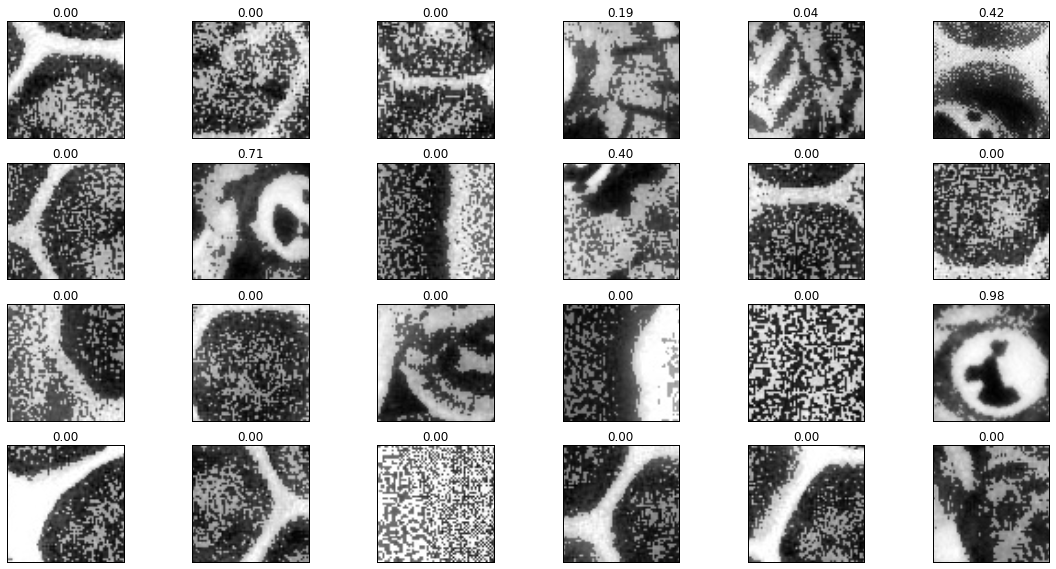

In [6]:
fig = visualization.plot_sample_images(X_train, y_train)

In [7]:
filtersize = (16, 16)

Xs_train = util.resize_data(X_train, filtersize)
Xs_val   = util.resize_data(X_val, filtersize)
Xs_test  = util.resize_data(X_test, filtersize)

print(Xs_train.shape)
print(Xs_test.shape)
print(Xs_val.shape)

329728/329073 [==============================] - 91s    
(658145, 1, 16, 16)
(329073, 1, 16, 16)
(329072, 1, 16, 16)


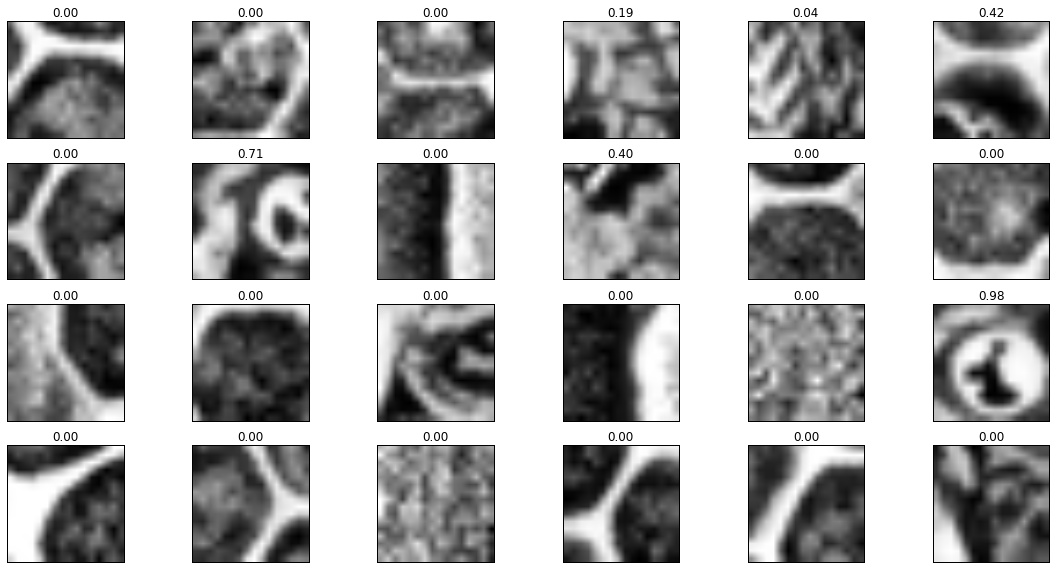

In [8]:
fig = visualization.plot_sample_images(Xs_train, y_train)

In [9]:
saliency_network = models.get_saliency_network(train=True)

In [10]:
saliency_datagen = keras_helpers.get_datagen(Xs_train)
#saliency_class_weight = utils.class_weight.compute_class_weight('auto', [0, 1], y_train[:, 1])
saliency_class_weight = [1., 1.]
#print(saliency_class_weight)
saliency_weight_file = join(data_dir, 'weights', 'saliency-weights')

In [ ]:
saliency_history = keras_helpers.fit_model(saliency_network, saliency_datagen, Xs_train, y_train, Xs_val, y_val,
                                           saliency_weight_file, saliency_class_weight, batchsize=4096, categorial=False)

In [37]:
batch_error = np.array([hist[0] for hist in saliency_history.batch_hist])

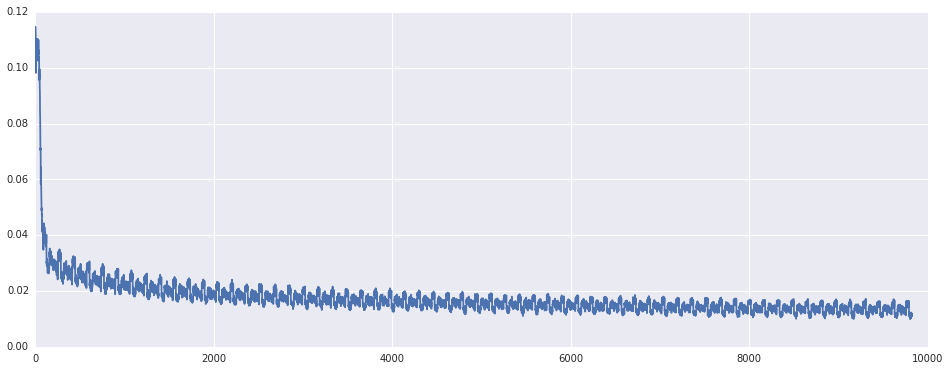

In [290]:
plt.figure(figsize=(16, 6))
_ = plt.plot(batch_error)

In [42]:
saliency_network.load_weights(saliency_weight_file)

In [43]:
ys_out = keras_helpers.predict_model(saliency_network, Xs_test, saliency_datagen)

329080/329073 [==============================] - 98s    


In [46]:
max(ys_out[:, 1])

0.98185664415359497

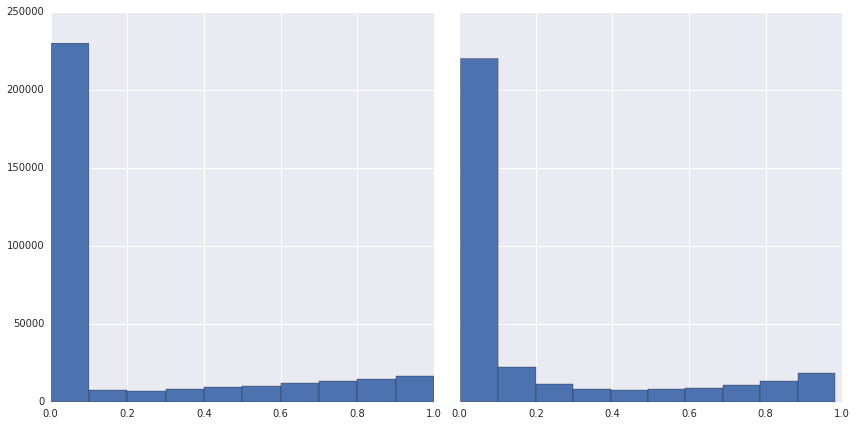

In [291]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(12, 6))
axes.flat[0].hist(y_test[:])
axes.flat[1].hist(ys_out[:, 1])

plt.tight_layout()

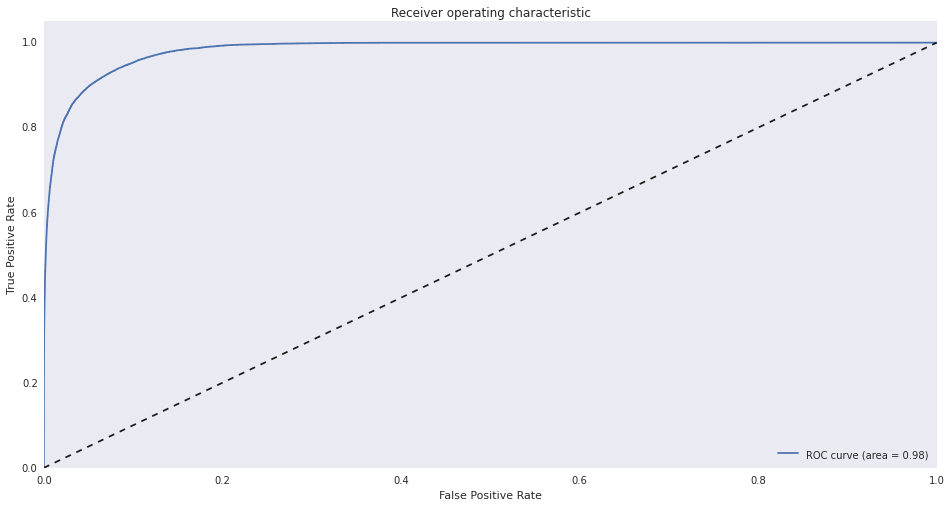

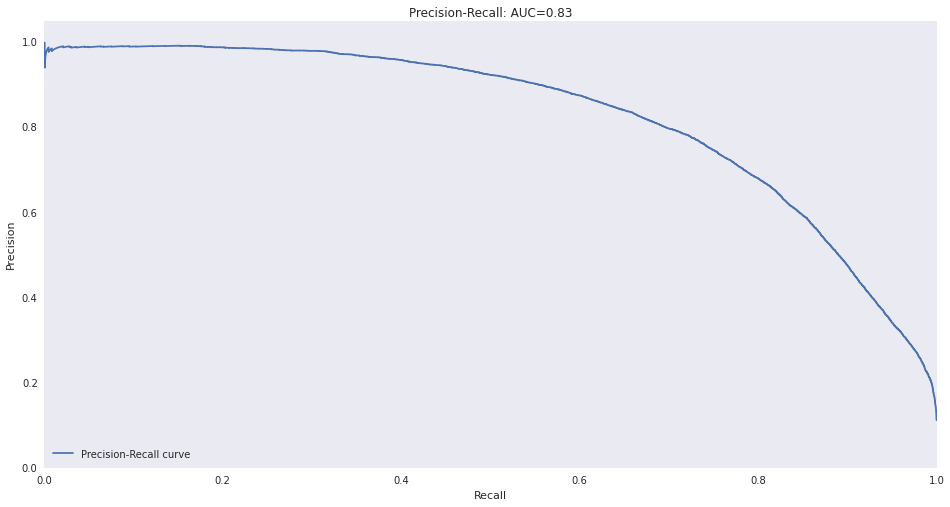

In [363]:
precision, recall, average_precision, thresholds, fpr, tpr, roc_auc = keras_helpers.evaluate_model(
    y_test > 0.9, ys_out, visualize=True)

In [364]:
saliency_threshold = keras_helpers.select_threshold(precision, recall, thresholds, min_value=0.95, optimize='recall')

('Recall', 0.95000304859459794)
('Precision', 0.3413367800731702)
('Threshold', 0.65929710865020752)
('F_2', 0.70026336841916026)
('F_0.5', 0.39150405298785362)


In [365]:
saliency_convolution_model = models.get_saliency_network(train=False)

In [366]:
convolution_function = keras_helpers.get_convolution_function(saliency_network, saliency_convolution_model)

In [367]:
image_path = join(expanduser("~"), 'deeplocalizer_data')
with open(join(image_path, 'test.txt'), 'r') as f:
    image_files = [line.split('\n')[0] for line in f.readlines()]

In [368]:
imfile = image_files[0]
image, image_filtersize, image_filtersize_unpadded, targetsize = util.preprocess_image(join(image_path, imfile), filtersize)

In [369]:
%%%timeit
convolution_function(image_filtersize_unpadded.reshape((1, 1, image_filtersize_unpadded.shape[0], image_filtersize_unpadded.shape[1])))

1 loops, best of 3: 617 ms per loop


In [370]:
saliency = convolution_function(image_filtersize_unpadded.reshape((1, 1, image_filtersize_unpadded.shape[0], image_filtersize_unpadded.shape[1])))

/usr/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


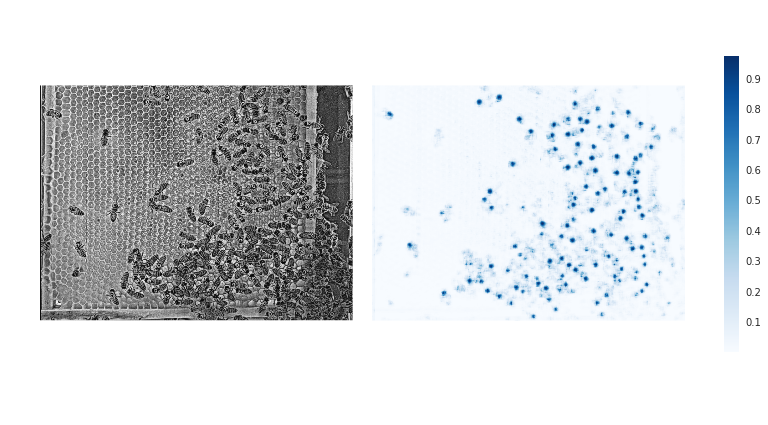

In [371]:
_ = visualization.plot_saliency_image(image_filtersize_unpadded, saliency[0][0, 0], filtersize, figsize=(12, 6))

#plt.savefig('saliency.png', dpi=300, bbox_inches='tight')

In [382]:
candidates = util.get_candidates(saliency, saliency_threshold)

In [383]:
rois, saliencies = util.extract_rois(candidates, saliency, image)

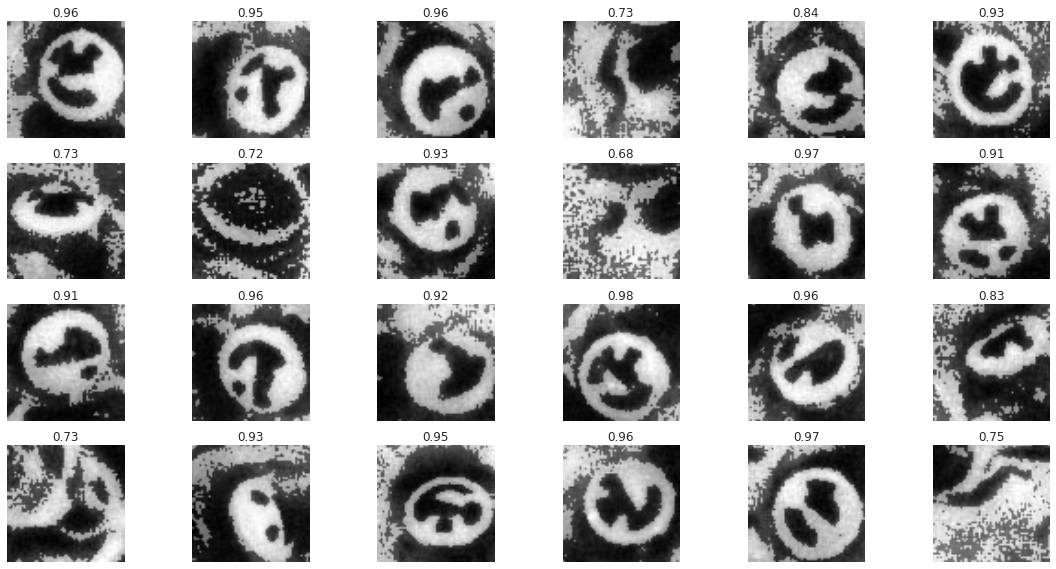

In [384]:
fig = visualization.plot_sample_images(rois, saliencies)

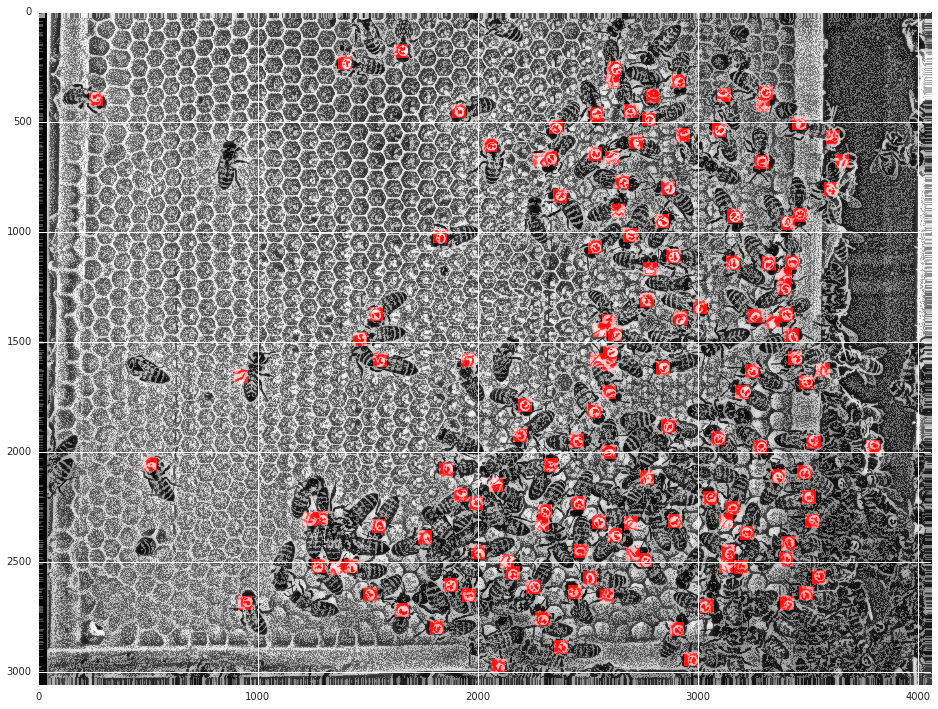

In [385]:
plt.figure(figsize=(16, 16))
_ = plt.imshow(visualization.get_roi_overlay(candidates, image))

In [51]:
filter_by_saliency = lambda x, y, z: keras_helpers.filter_by_threshold(x, y, z, saliency_threshold, saliency_network, saliency_datagen)
Xf_train, yf_train = filter_by_saliency(X_train, Xs_train, y_train)
Xf_test, yf_test = filter_by_saliency(X_test, Xs_test, y_test)
Xf_val, yf_val = filter_by_saliency(X_val, Xs_val, y_val)

329136/329135 [==============================] - 97s    
(329135,)
37464/37459 [==============================] - 11s    
(37459,)
37464/37459 [==============================] - 11s    
(37459,)


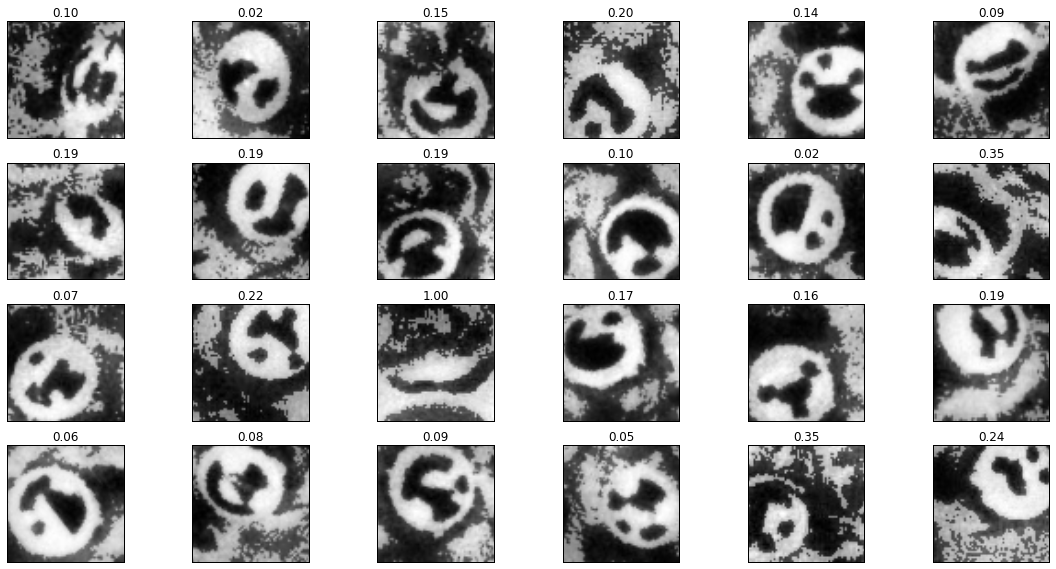

In [52]:
#fig = visualization.plot_sample_images(X_train, y_train)
fig = visualization.plot_sample_images(Xf_train, np.hstack((1 - yf_train, yf_train)))

In [205]:
filter_network = models.get_filter_network()

In [ ]:
filter_datagen = keras_helpers.get_datagen(X_train)
#filter_class_weight = utils.class_weight.compute_class_weight('auto', [0, 1], yf_train[:, 1])
filter_class_weight = [1., 1.]
print(filter_class_weight)
filter_weight_file = join(data_dir, 'weights', 'filter-weights')

[1.0, 1.0]


In [ ]:
filter_history = keras_helpers.fit_model(filter_network, filter_datagen, X_train, y_train, X_val, y_val,
                                         filter_weight_file, filter_class_weight, batchsize=128, categorial=False)

Epoch 0
329072/329072 [==============================] - 76s - test loss: 0.0046 - test acc: 1.0000    

Epoch 1
329072/329072 [==============================] - 76s - test loss: 0.0041 - test acc: 1.0000    

Epoch 2
240000/658145 [=========>....................] - ETA: 406s - train loss: 0.0047 - train acc: 1.0000

In [55]:
filter_history = keras_helpers.fit_model(filter_network, filter_datagen, Xf_train, yf_train, Xf_val, yf_val,
                                         filter_weight_file, filter_class_weight, batchsize=1024, categorial=False)

Epoch 0
5444/5444 [==============================] - 0s - test loss: 0.0663 - test acc: 1.0000     

Epoch 1
5444/5444 [==============================] - 0s - test loss: 0.0318 - test acc: 1.0000     

Epoch 2
5444/5444 [==============================] - 0s - test loss: 0.0299 - test acc: 1.0000     

Epoch 3
5444/5444 [==============================] - 0s - test loss: 0.0183 - test acc: 1.0000     

Epoch 4
5444/5444 [==============================] - 0s - test loss: 0.0139 - test acc: 1.0000     

Epoch 5
5444/5444 [==============================] - 0s - test loss: 0.0190 - test acc: 1.0000     

Epoch 6
5444/5444 [==============================] - 0s - test loss: 0.0107 - test acc: 1.0000     

Epoch 7
5444/5444 [==============================] - 0s - test loss: 0.0127 - test acc: 1.0000     

Epoch 8
5444/5444 [==============================] - 0s - test loss: 0.0192 - test acc: 1.0000     

Epoch 9
5444/5444 [==============================] - 0s - test loss: 0.0103 - test acc: 1.0

In [56]:
filter_network.load_weights(filter_weight_file)

In [57]:
yf_out = keras_helpers.predict_model(filter_network, Xf_test, filter_datagen)

5264/5258 [==============================] - 3s     


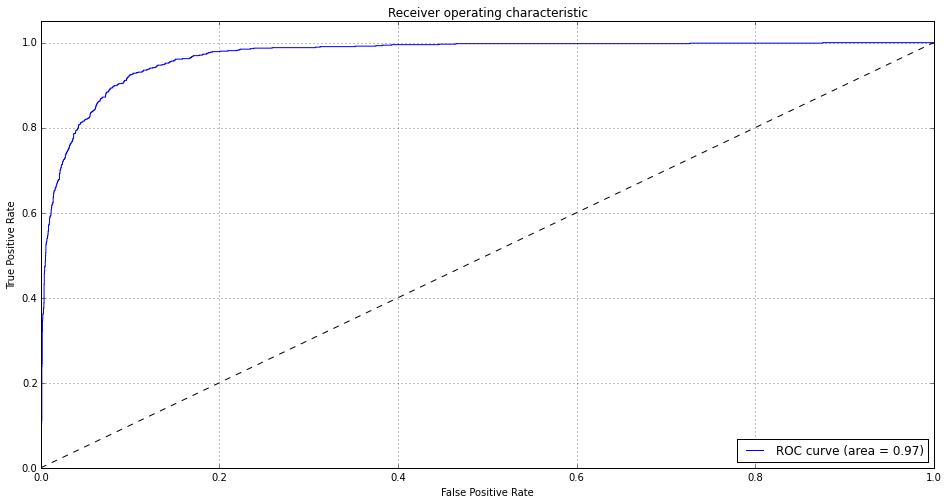

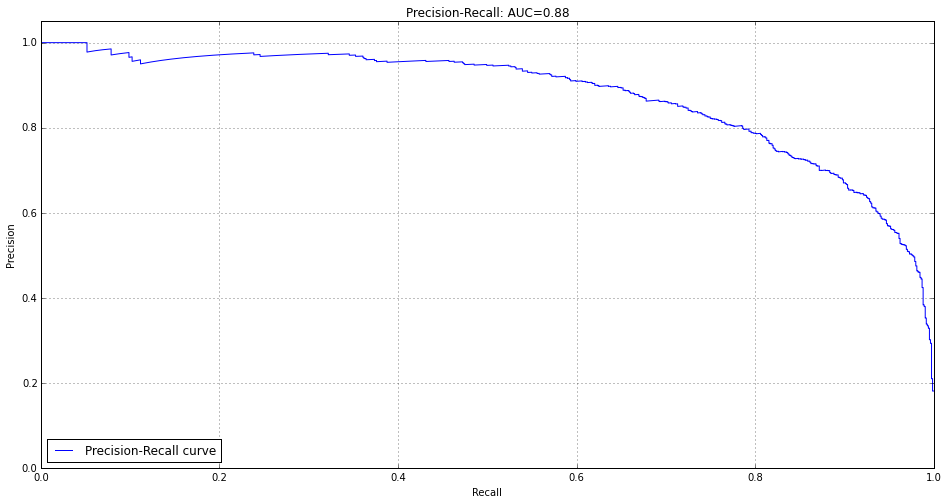

In [58]:
precision, recall, average_precision, thresholds, fpr, tpr, roc_auc = keras_helpers.evaluate_model(
    yf_test > 0.95, yf_out, visualize=True)

In [59]:
filter_threshold = keras_helpers.select_threshold(precision, recall, thresholds, min_value=0.90, optimize='precision')

('Recall', 0.62397179788484136)
('Precision', 0.90000000000000002)
('Threshold', 0.96962130069732666)
('F_2', 0.6647471206810216)
('F_0.5', 0.82684521955777024)


In [60]:
yf_out = keras_helpers.predict_model(filter_network, Xf_test, filter_datagen)

5264/5258 [==============================] - 3s     


(array([  326.,    36.,    19.,    24.,    49.,   222.,   798.,   682.,
         1177.,  1925.]),
 array([  5.54780709e-04,   1.00173438e-01,   1.99792095e-01,
          2.99410753e-01,   3.99029410e-01,   4.98648068e-01,
          5.98266725e-01,   6.97885382e-01,   7.97504040e-01,
          8.97122697e-01,   9.96741354e-01]),
 <a list of 10 Patch objects>)

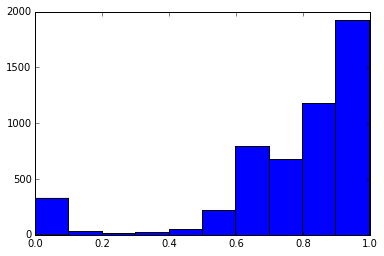

In [61]:
plt.hist(yf_out[:, 1])

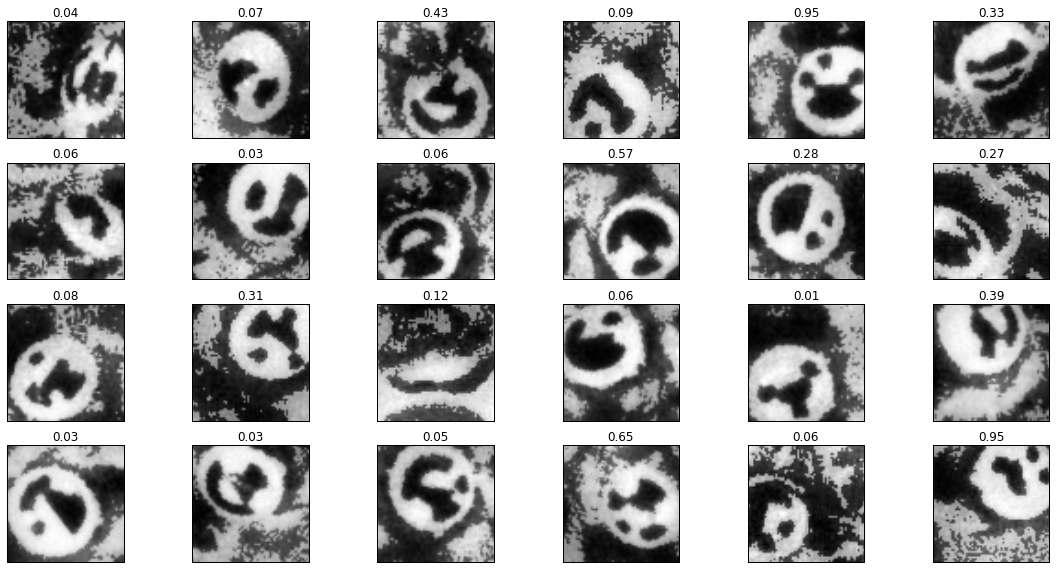

In [62]:
fig = plt.figure(figsize=(16, 8))
num = 24
_ = visualization.plot_sample_images(Xf_train[:num], yf_out[:num], num=num, fig=fig)

In [63]:
yf_out = keras_helpers.predict_model(filter_network, images / 255., filter_datagen)
#yf_out = filter_network.predict_proba(X_test)

NameError: name 'images' is not defined

In [ ]:
plt.hist(yf_out[:, ])

In [ ]:
num = int(6 * np.floor(len(candidates) / 6))
fig = plt.figure(figsize=(16, 8 / 24 * num))
_ = visualization.plot_sample_images(images[:num], yf_out[:num], num=num, fig=fig)

In [ ]:
from theano import tensor as T
from theano.ifelse import ifelse
import theano
from theano.tensor.nnet.neighbours import images2neibs

roisize = 61

t = T.scalar('t')
s = T.vector('s')

#cen = T.add(T.floor(roisize / 2.), 1)
pos = T.floor(s.shape / 2.).astype('int8')

z_ismax = ifelse(T.all(T.eq(T.argmax(s), pos)), 1, 0)

f_switch = theano.function([s], z_ismax,
                           mode=theano.Mode(linker='vm'))

test = np.array([1, 1, 1, 1, 5, 7, 1, 1, 1], dtype=np.float32)

f_switch(test)

# Defining variables
images = T.tensor4('images')
neibs = images2neibs(images, neib_shape=(roisize, roisize), neib_step=(1, 1), mode='valid')

# Constructing theano function
window_function = theano.function([images], neibs)

# Input tensor (one image 10x10)
im_val = saliency[0]

# Function application
neibs_val = window_function(im_val)

plt.figure()
plt.imshow(neibs_val[50].reshape((roisize, roisize)), cmap=plt.cm.Blues)
plt.show()

images = T.tensor4('images')
neibs = images2neibs(images, neib_shape=(roisize, roisize), neib_step=(1, 1), mode='valid')
pos = np.floor(roisize / 2.)
results, updates = theano.scan(lambda x_i: ifelse(T.all(T.eq(T.argmax(x_i, axis=0), pos)), 1, 0), sequences=[neibs])
compute_norm_lines = theano.function(inputs=[images], outputs=[results])

out = compute_norm_lines(saliency[0])

out2 = out[0].reshape(((saliency[0][0, 0].shape[0] - roisize + 1), (saliency[0][0, 0].shape[1] - roisize + 1)))

plt.figure()
plt.imshow(out2, cmap=plt.cm.Blues)
plt.show()